In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys
print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("../..")
print("at directory:", os.getcwd())

at directory: /Users/wilka/git/research/jaxneurorl/projects/humansf
changing to root directory
at directory: /Users/wilka/git/research/jaxneurorl


In [3]:
import jax
import jax.numpy as jnp
import json
import functools

from xminigrid.rendering.rgb_render import render
import numpy as np
from IPython.display import Image

from library import parallel

from singleagent import value_based_basics as vbb

from projects.humansf import visualizer
from projects.humansf import keyroom
from projects.humansf import keyroom_symbolic as symbolic
from projects.humansf import minigrid_common

In [4]:
# Open the file and load the JSON data
with open("projects/humansf/maze_pairs.json", "r") as file:
    maze_config = json.load(file)[0]

In [6]:
from pprint import pprint


pprint(maze_config)

env = symbolic.KeyRoomSymbolic()
env_params = env.default_params(
    maze_config=keyroom.shorten_maze_config(maze_config, 3)
)
env_params

{'keys': [['key', 'grey'],
          ['key', 'red'],
          ['key', 'purple'],
          ['key', 'yellow']],
 'pairs': [[['box', 'blue'], ['ball', 'blue']],
           [['box', 'purple'], ['box', 'green']],
           [['ball', 'green'], ['box', 'yellow']],
           [['key', 'blue'], ['key', 'green']]]}


SymbolicKeyRoomEnvParams(height=19, width=19, view_size=7, render_mode='rgb_array', random_door_loc=False, train_multi_probs=0.5, training=True, maze_config={'keys': Array([[9, 8],
       [9, 3],
       [9, 6]], dtype=uint8), 'pairs': Array([[[6, 5],
        [5, 5]],

       [[6, 6],
        [6, 4]],

       [[5, 4],
        [6, 7]]], dtype=uint8)}, task_objects=Array([[[ 9,  8,  1,  1],
        [12,  8,  1,  0],
        [ 6,  5,  1,  1],
        [ 5,  5,  1,  1]],

       [[ 9,  3,  1,  1],
        [12,  3,  1,  0],
        [ 6,  6,  1,  1],
        [ 6,  4,  1,  1]],

       [[ 9,  6,  1,  1],
        [12,  6,  1,  0],
        [ 5,  4,  1,  1],
        [ 6,  7,  1,  1]]], dtype=uint8), train_w=Array([[0.25, 0.5 , 1.  , 0.  ],
       [0.25, 0.5 , 1.  , 0.  ],
       [0.25, 0.5 , 1.  , 0.  ]], dtype=float32), test_w=Array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32), action_objects=Array([[9, 8],
       [9, 3],
       [9, 6],
       [6, 5],
     

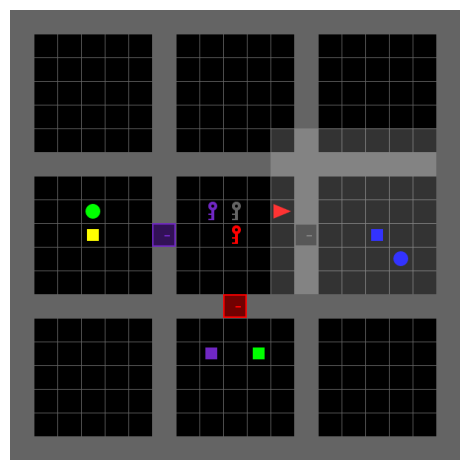

In [8]:
seed=3
rng = jax.random.PRNGKey(seed)
timestep = env.reset(rng, env_params)

# get image of full state
state_image = env.render(env_params, timestep)
visualizer.display_image(state_image)

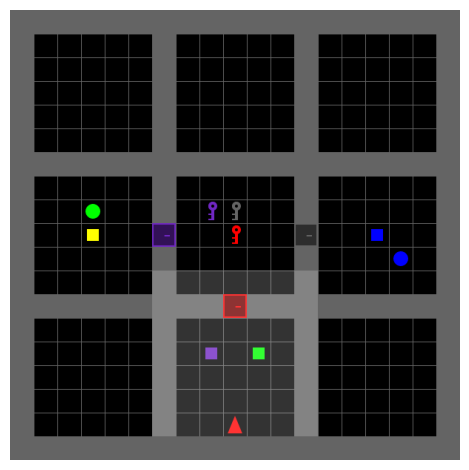

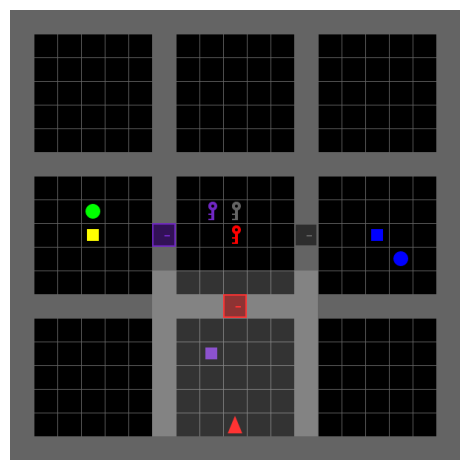

In [23]:
timestep = env.reset(rng, env_params)

# get image of full state
timestep = env.step(rng, timestep, 1, env_params)
state_image = env.render(env_params, timestep)
visualizer.display_image(state_image)

timestep = env.step(rng, timestep, 6, env_params)
state_image = env.render(env_params, timestep)
visualizer.display_image(state_image)

# Checking tasks (training)

2: reward: 0.0 | done= False


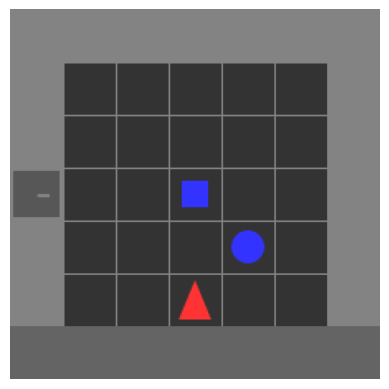

task_object 0
[0.25 0.5  1.   0.   0.   0.   0.   0.  ]
3: reward: 1.0 | done= True


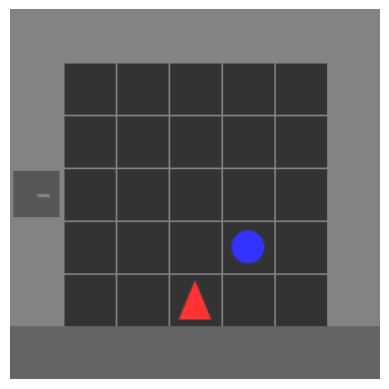

--------------------
transfer_object 1
[0.   0.   0.   0.   0.25 0.5  1.   0.  ]
3: reward: 0.0 | done= True


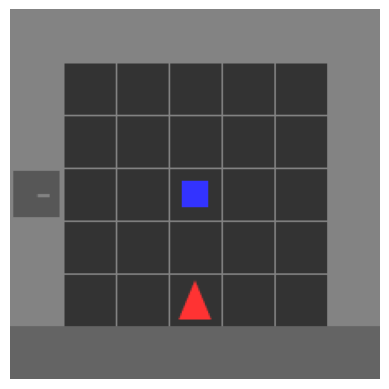

2: reward: 0.0 | done= False


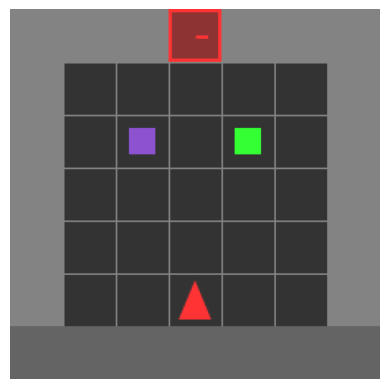

task_object 2
[0.   0.   0.   0.   0.25 0.5  1.   0.  ]
3: reward: 1.0 | done= True


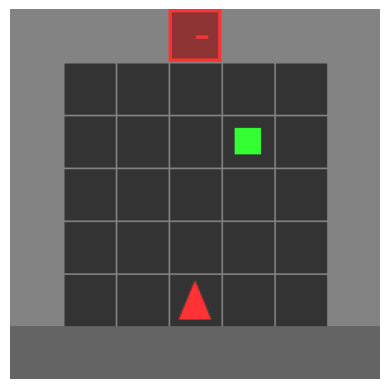

--------------------
transfer_object 3
[0.   0.   0.   0.   0.25 0.5  1.   0.  ]
3: reward: 0.0 | done= True


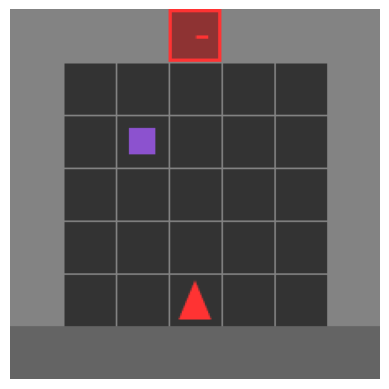

In [8]:
import matplotlib.pyplot as plt

task_object_idx = 0
params = env_params.replace(training=True)
keys = params.maze_config['keys']
goal_rooms = list(range(len(keys)))

for goal_room_idx in goal_rooms:
    print('='*50)
    goal_room_objects = params.task_objects[goal_room_idx]
    feature_weights = params.train_w*jax.nn.one_hot(goal_room_idx, len(keys))[:, None]

    # set task
    timestep = env.reset(rng, env_params)
    timestep1 = timestep.replace(
        state=timestep.state.replace(
            goal_room_idx=goal_room_idx,
            feature_weights=feature_weights,
            termination_object=goal_room_objects[2],
        )
    )

    # get first key + go to room
    action = goal_room_idx
    timestep2 = env.step(rng, timestep1, action, env_params)
    print("2: reward:", timestep2.reward, "| done=", timestep2.last())
    obs_image = keyroom.render_room(timestep2.state)
    visualizer.display_image(obs_image)
    plt.show()

    # pick up task object
    task_object = (2*goal_room_idx)
    action = len(keys) + task_object
    print('task_object', task_object)
    timestep3 = env.step(rng, timestep2, action, env_params)
    obs_image = keyroom.render_room(timestep3.state)
    visualizer.display_image(obs_image)

    print(timestep3.observation.task_w)
    print("3: reward:", timestep3.reward, "| done=", timestep3.last())
    plt.show()

    print('-'*20)
    # pick up transfer object
    task_object = (2*goal_room_idx) + 1
    action = len(keys) + task_object
    print('transfer_object', task_object)
    timestep3 = env.step(rng, timestep2, action, env_params)
    obs_image = keyroom.render_room(timestep3.state)
    visualizer.display_image(obs_image)
    print(timestep1.observation.task_w)
    print("3: reward:", timestep3.reward, "| done=", timestep3.last())
    plt.show()




In [57]:
state = timestep3.state
keys = params.maze_config['keys']
nkeys = len(keys)
pairs = params.maze_config['pairs'].reshape(-1, 2)
pairs.shape, state.agent.pocket.shape
non_key_picked_up = (pairs == state.agent.pocket[None]).all(-1)
terminate = non_key_picked_up.any()
terminate

Array(True, dtype=bool)

# Checking tasks (testing)

task_object 0


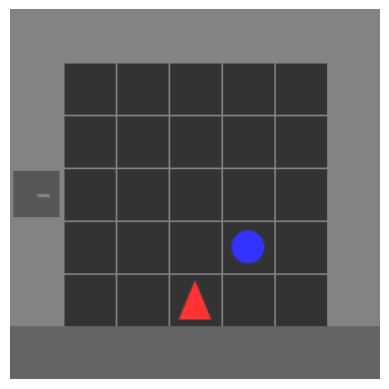

[0.25 0.5  1.   0.   0.   0.   0.   0.  ]
reward: 1.0 | done= False
--------------------

transfer_object 1
[0. 0. 0. 1. 0. 0. 0. 0.]
reward: 1.0 | done= False


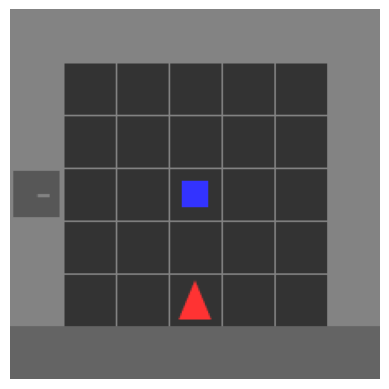

task_object 2


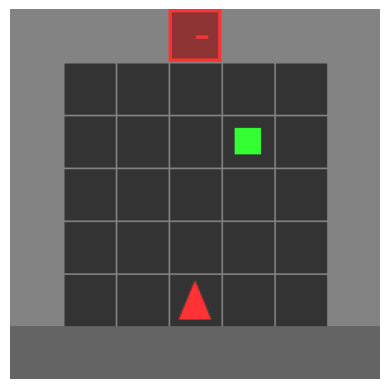

[0.   0.   0.   0.   0.25 0.5  1.   0.  ]
reward: 1.0 | done= True
--------------------

transfer_object 3
[0. 0. 0. 0. 0. 0. 0. 1.]
reward: 1.0 | done= False


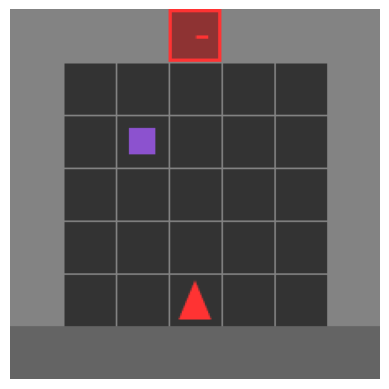

In [39]:
import matplotlib.pyplot as plt

task_object_idx = 0
params = env_params.replace(training=False)
keys = params.maze_config['keys']
goal_rooms = list(range(len(keys)))

for goal_room_idx in goal_rooms:
    print('='*50)
    goal_room_objects = params.task_objects[goal_room_idx]

    # set task
    timestep1 = timestep

    # get first key + go to room
    action = goal_room_idx
    timestep2 = env.step(rng, timestep1, action, env_params)
    
    # pick up task object
    task_object = (2*goal_room_idx)
    action = len(keys) + task_object
    print('task_object', task_object)
    timestep3 = env.step(rng, timestep2.replace(
        state=timestep2.state.replace(
            goal_room_idx=goal_room_idx,
            feature_weights=params.train_w*jax.nn.one_hot(goal_room_idx, len(keys))[:, None],
            # termination_object=goal_room_objects[2],
        )
    ), action, env_params)
    obs_image = keyroom.render_room(timestep3.state)
    visualizer.display_image(obs_image)
    plt.show()
    print(timestep3.observation.task_w)
    print("reward:", timestep3.reward, "| done=", timestep3.last())

    print('-'*20)
    # pick up transfer object
    task_object = (2*goal_room_idx) + 1
    action = len(keys) + task_object
    print('\ntransfer_object', task_object)
    timestep3 = env.step(rng, timestep2.replace(
        state=timestep2.state.replace(
            goal_room_idx=goal_room_idx,
            feature_weights=params.test_w*jax.nn.one_hot(goal_room_idx, len(keys))[:, None],
            # termination_object=goal_room_objects[3],
        )
    ), action, env_params)

    obs_image = keyroom.render_room(timestep3.state)
    visualizer.display_image(obs_image)
    print(timestep3.observation.task_w)
    print("reward:", timestep3.reward, "| done=", timestep3.last())
    plt.show()
    # break




# Random


task_w [0.   0.   0.   0.   0.25 0.5  1.   0.  ]
task_object 2


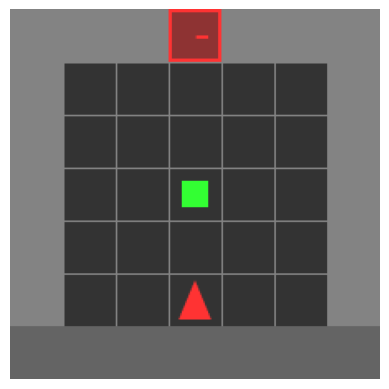

3: reward: 1.0 | done: True

task_w [0.   0.   0.   0.   0.25 0.5  1.   0.  ]
direction [1. 0. 0. 0.]
state_features [0. 0. 0. 0. 0. 0. 1. 0.]
has_occurred [0. 0. 0. 0. 0. 0. 1. 0.]
local_position [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
position [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
pocket [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0.]
prev_action [0. 0. 0. 0. 1. 0. 0.]

task_w [0.25 0.5  1.   0.   0.   0.   0.   0.  ]
task_object 0


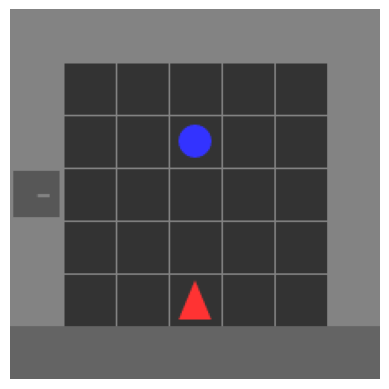

3: reward: 1.0 | done: True

task_w [0.25 0.5  1.   0.   0.   0.   0.   0.  ]
direction [1. 0. 0. 0.]
state_features [0. 0. 1. 0. 0. 0. 0. 0.]
has_occurred [0. 0. 1. 0. 0. 0. 0. 0.]
local_position [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
position [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
pocket [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0.]
prev_action [0. 0. 1. 0. 0. 0. 0.]


In [29]:
def print_timestep(t):
    observation = jax.tree_map(lambda x: x.astype(jnp.float32), t.observation)
    
    attrs = [
        "task_w",
        "direction",
        "state_features",
        "has_occurred",
        "local_position",
        "position",
        "pocket",
        "prev_action",
    ]
    for attr in attrs:
        print(attr, getattr(observation, attr))
    
import matplotlib.pyplot as plt

params = env_params.replace(training=True)
keys = params.maze_config['keys']
goal_rooms = list(range(len(keys)))

for seed in range(1,3):
    print()
    print('='*50)
    print('='*50)
    rng = jax.random.PRNGKey(seed)
    
    # set task
    timestep1 = timestep = env.reset(rng, params)
    print('task_w', timestep1.observation.task_w)
    print('='*50)
    for goal_room_idx in goal_rooms:

    
        # get first key + go to room
        action = goal_room_idx
        timestep2 = env.step(rng, timestep1, action, env_params)
        # obs_image = keyroom.render_room(timestep2.state)
        # visualizer.display_image(obs_image)
        # plt.show()

        
        # pick up task object
        task_object = (2*goal_room_idx)
        action = len(keys) + task_object
        timestep3 = env.step(rng, timestep2, action, env_params)
        if timestep3.reward > 0:
            print('task_object', task_object)
            obs_image = keyroom.render_room(timestep3.state)
            visualizer.display_image(obs_image)
            plt.show()
            print("3: reward:", timestep3.reward, "| done:", timestep3.last())
            print()
            print_timestep(timestep3)
    
        # pick up transfer object
        task_object = (2*goal_room_idx) + 1
        action = len(keys) + task_object
        timestep3 = env.step(rng, timestep2, action, env_params)
        if timestep3.reward > 0:
            print('task_object', task_object)
            obs_image = keyroom.render_room(timestep3.state)
            visualizer.display_image(obs_image)
            plt.show()
            print("3: reward:", timestep3.reward, "| done:", timestep3.last())
            print()
            print_timestep(timestep3)
    


In [22]:
timestep3.state.agent.direction

Array(0, dtype=int32)